In [32]:
import konlpy
import gensim
import sklearn
import seaborn

import numpy as np
from numpy import dot
from numpy.linalg import norm

import matplotlib.pyplot as plt

### Step 0: 데이터 확인

In [2]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

### Step 1.형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [3]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [4]:
print(len(tokenized))

71156


### Step 2. 추출된 결과로 embedding model 만들기

In [5]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8890190720558167),
 ('다큐멘터리', 0.8453171849250793),
 ('드라마', 0.8287919163703918),
 ('영화로', 0.8105509877204895),
 ('코미디', 0.7928603887557983),
 ('소재', 0.7857503294944763),
 ('형식', 0.7832783460617065),
 ('주제', 0.7712209224700928),
 ('감동', 0.7656300663948059),
 ('스토리', 0.7574694752693176)]

In [6]:
model.wv.most_similar(positive=['액션'])

[('리얼', 0.9000661969184875),
 ('시대극', 0.8823457360267639),
 ('대작', 0.8788551092147827),
 ('블록버스터', 0.8738406896591187),
 ('탄생', 0.8738036751747131),
 ('예산', 0.8729546666145325),
 ('호러', 0.8724135756492615),
 ('시청자', 0.8712814450263977),
 ('퍼포먼스', 0.8708546161651611),
 ('변모', 0.870654821395874)]

### Step 3. target, attribute 단어 셋 만들기

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt



def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
#         print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [8]:
art = read_token('synopsis_art.txt')
gen = read_token('synopsis_gen.txt')

In [9]:
len(art), len(gen)

(620208, 3014815)

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. ㄺㄷㅁㅇ
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

In [12]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [13]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [15]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

In [16]:
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [18]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [19]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [20]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [21]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [23]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

### Step 4. WEAT score 계산과 시각화

In [24]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [27]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [28]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

-0.509


In [29]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [30]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.50943166
SF 공연 -0.3746491
SF 공포(호러) -0.67876065
SF 기타 0.33080155
SF 다큐멘터리 0.5759477
SF 드라마 -0.3592449
SF 멜로로맨스 -0.8033363
SF 뮤지컬 0.32829526
SF 미스터리 -0.6986129
SF 범죄 -0.241237
SF 사극 -0.8065982
SF 서부극(웨스턴) -0.37601164
SF 성인물(에로) -0.583225
SF 스릴러 -0.5428061
SF 애니메이션 0.3404951
SF 액션 -0.45212978
SF 어드벤처 -0.73812646
SF 전쟁 0.32255492
SF 코미디 -0.422865
SF 판타지 -0.1584398
가족 공연 0.19844586
가족 공포(호러) -0.14969692
가족 기타 0.74073935
가족 다큐멘터리 0.83138317
가족 드라마 0.2298183
가족 멜로로맨스 -0.6282055
가족 뮤지컬 0.6961095
가족 미스터리 -0.30989507
가족 범죄 0.21420002
가족 사극 -0.03129404
가족 서부극(웨스턴) 0.51121175
가족 성인물(에로) -0.32773578
가족 스릴러 -0.1523617
가족 애니메이션 0.84417796
가족 액션 0.12661953
가족 어드벤처 0.03933853
가족 전쟁 0.7127387
가족 코미디 0.21546263
가족 판타지 0.43960622
공연 공포(호러) -0.24445997
공연 기타 0.8920844
공연 다큐멘터리 0.9213273
공연 드라마 0.023360077
공연 멜로로맨스 -0.71412194
공연 뮤지컬 0.86447006
공연 미스터리 -0.36290205
공연 범죄 0.07895149
공연 사극 -0.30089033
공연 서부극(웨스턴) 0.106057346
공연 성인물(에로) -0.49527022
공연 스릴러 -0.23246928
공연 애니메이션 0.87918776
공연 액션 -0.01835

<AxesSubplot:>

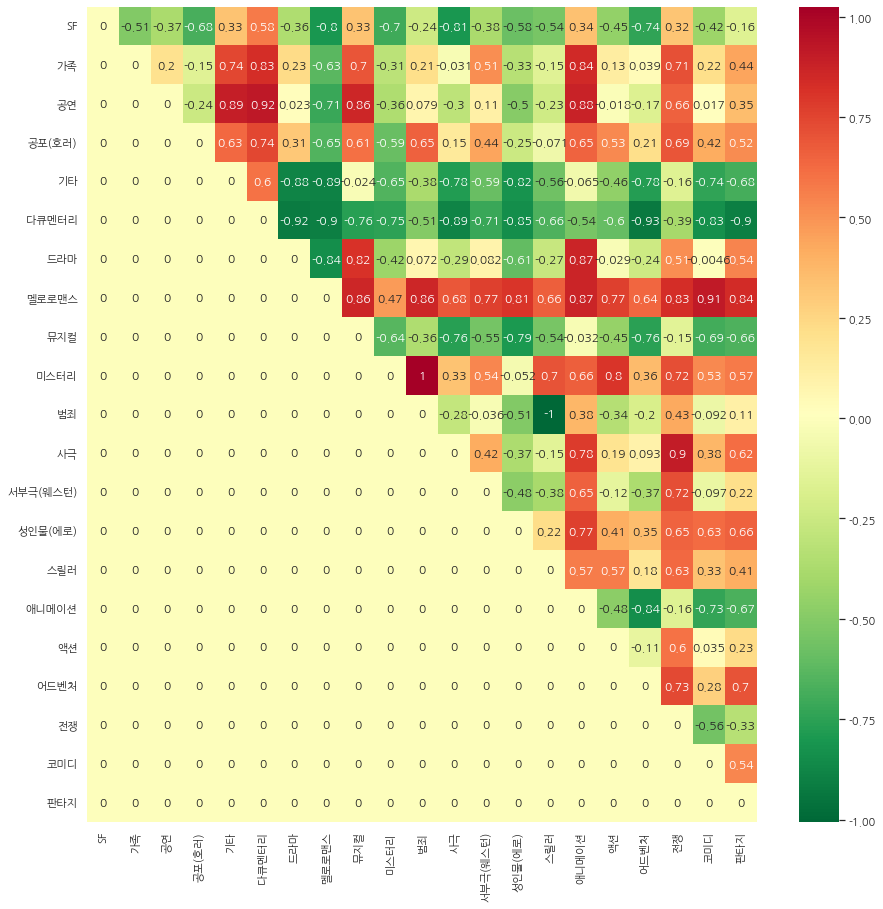

In [36]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,15))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

특징) 양의 상관관계만 살펴봤다.
- 미스터리와 범죄의 상관관계는 1이다.<br>
  직관적이어서 의문이 들지 않는다. <br><br>

- 공연과 다큐멘터리의 상관관계는 0.92이다.<br>
  <b>의문1)</b> 공연같은 유희를 위한 장르와 심오한 내용을 다루는 다큐멘터리의 상관관계가 0.92라는 것이 이상하다. <b>이 부분은 TF-IDF의 문제점과 연관있을수도 있다, 두 문서안에 비슷한 단어의 빈도수가 비슷한 수치로 높아서 두 장르의 상관관계가 높은 것으로 나온 것으로 예상하고 있다. </b><br><br>
  
- 멜로 로맨스와 코미디의 상관관계는 0.91이다. <br>
  <b>의문2)</b> 시대에 따라 다를 수도 있겠지만 요새 영화엔 배우들의 찰진 애드립과, 개그성 멘트등을 넣던데 그게 멜로로맨스라는 영화도 녹아있는건가 궁금하다. 분위기나 주제에 따라 멜로 로맨스 영화를 우울한 분위기가 될 수도 있을텐데, 주어진 텍스트 데이터에서의 상관관계가 높다고 하다면, 이 문서의 출처와 누가 문서를 작성(ex, 시나리오/대본 등이라면 그 작가님들)했느냐에 따라 문체 스타일에서도 차이가 날 수 있을것 같다.<br><br>

- 사극과 전쟁의 상관관계는 0.9이다 <br>
   직관적이어서 의문이 들지 않는다. <br><br>
   
- 공연과 기타의 상관관계는 0.89이다.<br>
  기타와 공연의 텍스트를 살펴봤을 때 공연의 작품성을 의미하는 객관적인 단어를 일부 포함하고 싶었다. 기타 텍스트를 봤을 때 역시 작품들을 평가하는 영화제, 국제 등의 단어가 확인된것으로 봐서 두 장르의 상관관계가 높은것이 이해가 됐다. <br><br>
  
- 드라마와 애니메이션, 멜로로맨스와 애니메이션의 상관관계는 0.87이다. <br>
  <b>의문3)</b> 사실상 의문이라기 보다는 왜 저런 단가 드라마 또는 애니메이션장르 안에 있는 건지 의문이다. 단어 자체가 좀 편향되어 있어서 상관관계가 높을 수 밖에 없다. <br><br>
  
- 공연과 뮤지컬, 멜로로맨스와 뮤지컬의 상관관계는 0.86이다. <br><br><br>


결론) <br>
①input한 데이터 자체가 일부 좀 편향되어 있는데 TF-IDF방법을 통과했을 때 편향성이 보인다라고 단정 지을 수는 없을 것 같다. 시도해 보지 않았지만 데이터가 이미 biased 되어 있는 걸로 봐서 어떤 방법을 써도 비슷한 결과가 나오지 않을까 하는 (이 마저도 biased)된 생각이 든다. <br><br>

② (연수님의 의견을 참고함) 전반적으로 '그녀', '위해' 라는 단어가 장르 불문하고 많이 쓰였다. 그래서 그런지 상관관계가 아예 없는 0인 값은 찾지 못했다.